In notebook 17.07 Feature Engineering 1: From Variables to Features, you saw techniques about how to transform variables into useful forms and when to create new features.  The ultimate goal in feature engineering is to determine the "best" set of features that you'll feed into your models.  But, what does that mean and how exactly do we define _best_?  The answer to these two questions are crucial to data science, but unfortunately there is no clear-cut answer.

Rather in data science you are constantly trying to strike a balance between trade-offs.  One of them is called the **curse of dimensionality**, which is discussed in this notebook.  Specifically, this notebook will cover: 
1. What is the curse of dimensionality? 
2. How to select the features that are most useful for the modeling phase.
3. A popular method of dimension reduction that's useful for feature selection.

### The Curse of Dimensionality

_The Curse of Dimensionality_ is the exponential increase in the number of combinaitons for the linear increase in the number of dimensions.

Each variable in a dataset is a dimension.  Running a model with 20 features (variables) has 20 dimensions.  If you have 2 values at 20 dimensions the number of combinations to search is $ 2^{20} = 1048576 $. Because of the curse of dimensionality the number of features you can include are limited by 2 problems: <br />
<ol>
    <li>The computation time may increase exponentially with every addition of a single feature to the model.  So, running models with many feature may become infeasable due to the time required to run them.</li>
    <li>To train the models, you use a sample from the data.  However, due to the curse of dimensionality, the number of datapoints required to train the models increases exponentially for every feature added to the model.  Consequently, finding a large enough sample may be impossible.</li>
</ol>
Because of these 2 problems you usually try to limit the number of features in a model.  To to that you need to select the most useful feature among all the variables in the dataset.

## Approaches in feature selection

You want to keep the features that have the strongest connection to the outcome, while also prioritiizing features that bring something unique to the table.  You want to settle on a set of features that is realively computationally efficient.  Feature selection algorithms fall into 4 broad groups: Filter methods, Wrapper methods, Embedded methods, Dimensionality reduction methods.

#### Filter methods
_Filter methods_ are good at selecting relevant features likely related to the target.  They are computationally simple and straightforward, but inclined to produce lists of redundant features since interfeature relationships are not considered.  They are good at reducing features before applying more computationally demanding algorithms.

#### Wrapper methods
_Wrapper methods_ are good at selecting useful sets of features that effectively predict the outcome.  For larger sets of features wrapper methods can be computationally intensive.

#### Embedded methods
_Embedded methods_ also select sets of features, but do so as an intrinsic part of the fitting method for the particular type of model you are using.  This may involve __regularization__, where a "complexity penalty" is added to the fitness measures typically used to assess the predictive power of a model.  Embedded methods provide the benefits of wrapper methods but are less computationally intensive.  Different types of models will use different embedded methods.

#### Dimensionality reduction methods
_Dimensionality reduction methods_ are especially useful when you have a lot of features and applying the other techniques mentioned might be computationally expensive.  One of the most popular techniques is __Principal Components Analysis (PCA)__.

## Principal Components Analysis (PCA)
_PCA_ is a complexity-reduction technique that tries to reduce a set of variables down to a smaller set of components that represent most of the information in the variables.  _PCA_ works by identifying sets of variables that shared variance and then creating a component to represent that variance.  _PCA_ considers the data from components with overlaping variance, data outside of the overlap is discarded.  Losing variance in exchange for a smaller set of features can be worthwhile.  

_PCA_ works best for normally distributed data and assumes the relationsships amoung variables are linear.  _PCA_ also works bes when the variables involved range from weak to moderately strong correlations.  Correlations of 0 or greater than 7 or 8, create problems.  Correlations near 0 mean there is no shared information.  Correlation that are too high can result in components that are unstable and, therefore, change a lot in response to a very small change in the data or components made up from variance from only 1 or 2 variables.  A few very high or very low correlations are fine.  It is when you have a variable with mostly very high or very low correlations with other variables that problems can occur.

\* A good reference video on PCA can be found here: [StatQuest: Principal Component Analysis (PCA), Step-by-Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

In [3]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd 

# from matplotlib.mlab import PCA as mlabPCA # New in this Thinkful module and unused
from sklearn.preprocessing import StandardScaler # New in this Thinkful module
from sklearn.decomposition import PCA # New in this Thinkful module
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL

import math # New in this Thinkful module
import warnings 
import missingno # Added to examine null values in assignment

warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set(style="whitegrid")

In [4]:
"""
    Demonstrate PCA using the FIFA 19 player dataset.  The dataset includes several features for players in the popular video game FIFA 19.  You'll use 34 correlated attributes  of the players like _Crossing_, _Finishing_, and _Dribbling_.  As the correlation table suggests, some features are highly correlated with each other.
"""
kagle = dict(
    drivername="postgresql", 
    username="dsbc_student", 
    password="7*.8G9QH21", 
    host="142.93.121.174", 
    port="5432", 
    database="fifa19"
)

engine = create_engine(URL(**kagle), echo=True)

fifa_df = pd.read_sql_query("SELECT * FROM fifa19", con=engine)

engine.dispose()

fifa_df = fifa_df.iloc[:, 53:87]

2020-01-02 09:49:34,055 INFO sqlalchemy.engine.base.Engine select version()
2020-01-02 09:49:34,057 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 09:49:34,157 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-01-02 09:49:34,158 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 09:49:34,255 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-01-02 09:49:34,257 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 09:49:34,308 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-01-02 09:49:34,309 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 09:49:34,366 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-01-02 09:49:34,367 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 09:49:34,464 INFO sqlalchemy.engine.base.Engine SELECT * FROM fifa19
2020-01-02 09:49:34,465 INFO sqlalchemy.engine.base.Engine {}


In [5]:
# Display the correlation table
fifa_df.corr()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
Crossing,1.000000,0.655300,0.469507,0.809660,0.690339,0.856647,0.833105,0.761107,0.756527,0.840916,...,0.645805,0.575446,0.443101,0.428963,0.409961,-0.663053,-0.660193,-0.659767,-0.660160,-0.662539
Finishing,0.655300,1.000000,0.473427,0.661830,0.882675,0.824337,0.759229,0.697550,0.512806,0.788376,...,0.837827,0.533414,0.024218,-0.033023,-0.071811,-0.588752,-0.587145,-0.583268,-0.584852,-0.586913
HeadingAccuracy,0.469507,0.473427,1.000000,0.640091,0.505639,0.550750,0.440846,0.407772,0.510779,0.658175,...,0.551978,0.507208,0.583123,0.561063,0.533643,-0.750417,-0.749888,-0.746444,-0.744443,-0.748895
ShortPassing,0.809660,0.661830,0.640091,1.000000,0.698309,0.843722,0.775398,0.736659,0.895722,0.911451,...,0.676063,0.685137,0.559576,0.541131,0.508644,-0.729785,-0.728024,-0.724381,-0.723782,-0.728721
Volleys,0.690339,0.882675,0.505639,0.698309,1.000000,0.809639,0.807285,0.749637,0.571050,0.794935,...,0.829257,0.595281,0.120919,0.072788,0.035457,-0.590808,-0.588668,-0.584954,-0.586131,-0.588670
Dribbling,0.856647,0.824337,0.550750,0.843722,0.809639,1.000000,0.842652,0.753600,0.722465,0.938942,...,0.769594,0.597498,0.336072,0.301251,0.273963,-0.754625,-0.753181,-0.749816,-0.751348,-0.754341
Curve,0.833105,0.759229,0.440846,0.775398,0.807285,0.842652,1.000000,0.861277,0.710807,0.829568,...,0.751833,0.616532,0.289529,0.261481,0.232869,-0.606286,-0.603141,-0.600266,-0.603540,-0.604960
FKAccuracy,0.761107,0.697550,0.407772,0.736659,0.749637,0.753600,0.861277,1.000000,0.703544,0.759548,...,0.734440,0.585120,0.297976,0.279153,0.247903,-0.556605,-0.553644,-0.549911,-0.552641,-0.554920
LongPassing,0.756527,0.512806,0.510779,0.895722,0.571050,0.722465,0.710807,0.703544,1.000000,0.788650,...,0.542247,0.645797,0.587106,0.587430,0.562230,-0.596820,-0.594999,-0.591453,-0.591561,-0.595887
BallControl,0.840916,0.788376,0.658175,0.911451,0.794935,0.938942,0.829568,0.759548,0.788650,1.000000,...,0.769791,0.674881,0.452705,0.417566,0.384802,-0.788444,-0.786797,-0.783423,-0.783607,-0.787939


Now, demonstrate the role of rotation in PCA in a 2-D space using only the _Crossing_ and _Finishing_ variables:

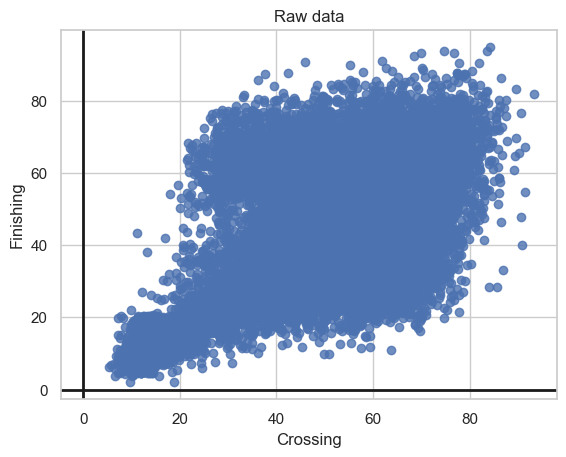

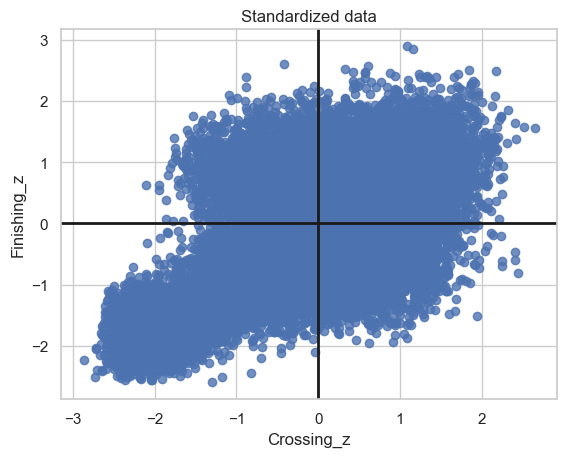

In [6]:
# Demonstrate the role of rotation in PCA in a 2-D space using only the Crossing and Finishing variables
t = sns.regplot(
    "Crossing", 
    "Finishing", 
    fifa_df, 
    x_jitter=0.49, 
    y_jitter=0.49, 
    fit_reg=False
)

t.axhline(0, color="k", linestyle="-", linewidth=2)
t.axvline(0, color="k", linestyle="-", linewidth=2)
t.axes.set_title("Raw data")
plt.show()

"""
    Standardizing variables by subtracting the mean and dividing by the standard deviation.  Now, both variables are on the same scale.
"""
fifa_st_df = pd.DataFrame()
fifa_st_df["Crossing_z"] = (fifa_df["Crossing"] - fifa_df["Crossing"].mean()) / fifa_df["Crossing"].std()
fifa_st_df["Finishing_z"] = (fifa_df["Finishing"] - fifa_df["Finishing"].mean()) / fifa_df["Finishing"].std()

t = sns.regplot(
    "Crossing_z", 
    "Finishing_z", 
    fifa_st_df, 
    x_jitter=0.49, 
    y_jitter=0.49, 
    fit_reg=False
)
t.axhline(0, color="k", linestyle="-", linewidth=2)
t.axvline(0, color="k", linestyle="-", linewidth=2)
t.axes.set_title("Standardized data")
plt.show()

In the plot above, both axes describe equal variance - they both from about -3 to 3.  If you were to drop one of the axes and describe the data using only the information from the other axis, you would lose roughly 50% of the information.

If you fit a line through the origin that minimizes the distance between the line and each point, and then rotate the data, the axes and their informaiton value will change.

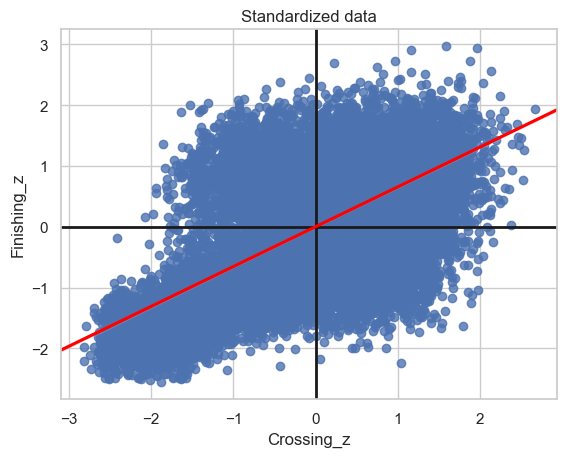

In [7]:
t = sns.regplot(
    "Crossing_z", 
    "Finishing_z", 
    fifa_st_df, 
    x_jitter=0.49, 
    y_jitter=0.49, 
    fit_reg=False
)
t.axhline(0, color="k", linestyle="-", linewidth=2)
t.axvline(0, color="k", linestyle="-", linewidth=2)
t.axes.set_title("Standardized data")

sns.regplot(
    "Crossing_z", 
    "Finishing_z", 
    fifa_st_df, 
    scatter=False, 
    color="red"
)

plt.show();

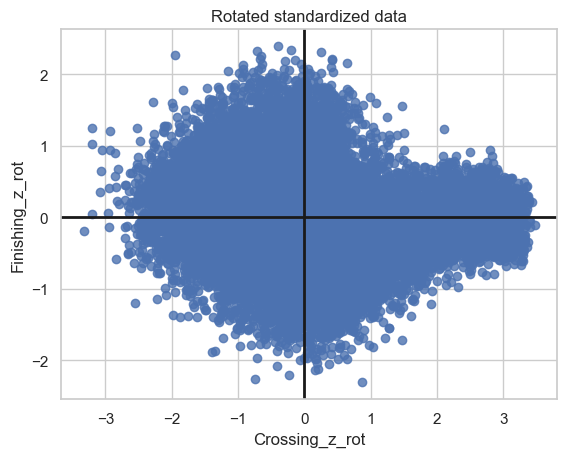

In [8]:
# Rotating the data so that the axes roughly match to vector above.
fifa_st_df['Crossing_z_rot'] = math.cos(40) * fifa_st_df['Crossing_z'] - math.sin(40) * fifa_st_df['Finishing_z']
fifa_st_df['Finishing_z_rot'] = math.sin(40) * fifa_st_df['Finishing_z'] + math.cos(40) * fifa_st_df['Crossing_z']

t = sns.regplot(
    "Crossing_z_rot", 
    "Finishing_z_rot", 
    fifa_st_df, 
    x_jitter=0.49, 
    y_jitter=0.49, 
    fit_reg=False
)
t.axhline(0, color="k", linestyle="-", linewidth=2)
t.axvline(0, color="k", linestyle="-", linewidth=2)
t.axes.set_title("Rotated standardized data")
plt.show();

In the image above, the horizontal vector is longer than the vertical vector, spanning from -4 to 4 rather -1 to 1.  The horizontal axis therefore contains more variance, and has a higher information value, than the vertical vector.  If you treated the axes as principal components and discarded the vertical vector, each datapoint would be described soley by its position on the horizontal axis.  The information on each datapoint's vertical position would be lost.  Because of the rotation, if you drop the vertical axis now you would lose less than 50% of the informaiton.

A significant part of doing PCA is deciding wether the gain from dropping a component from the feature pool is worth the loss of informaiton.

## The Math Behind PCA
The "rotation" above is based on calculating the covariance matrix of the data and applying a linear transformation (rotation) and deriving from that the eigenvalues and eigenvectors that express the amount of variance in the data explained by the new axes.
### Covariance Matrix 
A correlation matrix is a covariance matrix where the covariances have been divided by the variances.  This standardizes the covariances so they are all on the same scale (-1 to 1) and they can now be compared.  Covariance matricies, like correlation matricies, contain information about the amount of variance shared between pairs of variables.

The variance of $ x $ is the sum of the squared differences between each values in $ x(x_i) $ and the mean of $ x (\bar{x}) $ divided by the sample size $ (n) $.
$$ var(x) = \frac{\Sigma(x_i - \bar{x})^2}{n} $$

Note: The standard deviation is $ \sqrt{var(x)} $

The covariance between two variables $ x $ and $ y $ is the product of the differences of each variable value and its mean divided by the sample size.
$$ cov(A) = \Sigma \frac{(x_i - \bar{x})(y_i - \bar{y})}{n} $$

In [9]:
# Here is the covariance matrix for the FIFA 19 data
fifa_df = fifa_df.dropna()

# Normalize the data so that all variables have a mean of 0 and standard deviation of 1
X = StandardScaler().fit_transform(fifa_df)

# The NumPy covariance function assumes that variables are represented by rows, not columns, so you transpose X.
Xt = X.T
Cx = np.cov(Xt)
print(f"Covariance Matrix:\n{Cx}")

Covariance Matrix:
[[ 1.00005507  0.65533573  0.46953243 ... -0.65980319 -0.6601961
  -0.66257575]
 [ 0.65533573  1.00005507  0.4734528  ... -0.58330031 -0.5848846
  -0.5869451 ]
 [ 0.46953243  0.4734528   1.00005507 ... -0.74648538 -0.74448373
  -0.74893673]
 ...
 [-0.65980319 -0.58330031 -0.74648538 ...  1.00005507  0.96438954
   0.96639022]
 [-0.6601961  -0.5848846  -0.74448373 ...  0.96438954  1.00005507
   0.97018302]
 [-0.66257575 -0.5869451  -0.74893673 ...  0.96639022  0.97018302
   1.00005507]]


### Data as a Matrix
Because of the way matrix multiplication works, you can express the covariance matrix for $ X $ as the product of $ X $ and the transpose of $ X(X^T) $.  A matrix is transposed by flipping it on its diagonal so that the row and column indices are switched, such that: $ X = \begin{bmatrix} 1&2&3 \\ 2&3&6 \\ 2&1&9 \\ 4&5&1 \end{bmatrix} $ becomes: $ X^T = \begin{bmatrix} 1&2&2&4 \\ 2&3&1&5 \\ 3&6&9&1 \end{bmatrix} $ 

The covariance matrix for $ X $, by the logic of matrix multiplication, is therefore an _m_ by _m_ matrix where the diagnoal terms represent the variance of each variable and the off-diagonals are the covariances.  You represent the covariance matrix of $ X $ as C_x: 
$$ C_X = \frac{1}{n-1}XX^T $$

The covariance matrix for the FIFA 19 data was created by multiplying a matrix of data with dimensions 18,159 x 34 (18,159 rows x 34 varaibles) by the transpose of that matrix with dimensions 34 x 18,159.  Since you were interested in the covariance between the varaibles, you multiplied $ (X^T)X $.  The covariance matrix, as a result, has dimensions 34 x 34.

In PCA, the goal is to transform the covariance matrix so that all information is in the diagonals (variances) and none is in the off-diagnoals (covariances).  You do that by finding a matrix $ P $ where whey you mpultiply $ P $ and $ X $ you bet a matrix $ Y $ with a covariance matrix $ C_Y $ with only 0s on the off-diagnoals.

1. Start with the formula for the covariance of $ Y $: $ C_Y = \frac{1}{n-1}YY^T $
2. Then substitue $ PX = Y $: $ C_Y = \frac{1}{n-1}(PX)(PX)^T = \frac{1}{n-1}PXX^T P^T $
3. Finally, break it down into something familiar.  Remember that $ C_X = XX^T: C_Y = \frac{1}{n-1}P(XX^T)P^T $ <br /> $ P $ is a matrix where each row is an eigenvector of $ XX^T $

### Eigenvectors

An eigenvector is the directional aspect of a component – it's the red line in the previous graph. During PCA, the eigenvectors are chosen to be orthogonal, i.e., to have a correlation of 0 with each other. This selection process is done sequentially. First, a vector is found that minimizes the distance between the vector and the datapoints. This vector is the first component. Next, a 2nd vector is found that also minimizes the distance between it and the datapoints, the catch being this 2nd vector must be perpendicular to the 1st vector in 1 of the n-dimensions of the space. This procedure continues until there are n-vectors.

### Eigenvalues

Eigenvalues represent the length of the eigenvectors–each eigenvector has an eigenvalue. The length of the eigenvector encodes the proportion of total variance explained by a component. The total variance is equal to the number of variables in the PCA. Thus, an eigenvalue of 1 means that the component explains the same amount of variance as one variable. An eigenvalue greater than 1 is desirable, since a component with an eigenvalue of 1 adds no value beyond the information contained in any individual variable, and an eigenvalue of less than 1 is actually less efficient at conveying information than a variable by itself. An eigenvalue of 2 means that the component contains an amount of information equal to that of 2 variables. It does not mean that only 2 variables load on that component.

The proportion of the variance that each eigenvector represents can be calculated by dividing the eigenvalue corresponding to that eigenvector by the sum of all eigenvalues.

In [10]:
# Calculating eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)): 
    eigvec_cov = eig_vec_cov[:, i].T
    print(f"Eigenvector {i+1}: \n{eigvec_cov}")
    print(f"Eigenvalue {i+1}: {eig_val_cov[i]}")
    print(40 * "-")
    
print(f"The percentage of total variance in the dataset explained by each component calculated by hand.\n{eig_val_cov / sum(eig_val_cov)}")

Eigenvector 1: 
[ 0.20031595  0.17960135  0.16494839  0.21087143  0.18542573  0.21397064
  0.19617801  0.18312402  0.186724    0.22044379  0.16424625  0.1624329
  0.16678123  0.09792308  0.14590308  0.19692239  0.06061726  0.18570425
  0.02849067  0.19595275  0.14657334  0.11695874  0.20068377  0.16230508
  0.18109287  0.15539206  0.12426471  0.11747611  0.11021307 -0.19648369
 -0.19617625 -0.1953696  -0.1954223  -0.19629495]
Eigenvalue 1: 18.849144201671326
----------------------------------------
Eigenvector 2: 
[-0.04188421 -0.22162393  0.17520018  0.03223146 -0.17866954 -0.10445267
 -0.12066113 -0.09891488  0.06745204 -0.03766039 -0.1279576  -0.10640897
 -0.1632028   0.01563515 -0.13947955 -0.08463877  0.11637021  0.10149888
  0.23049983 -0.14678066  0.25950774  0.34905342 -0.1528266  -0.15114339
 -0.14906097  0.00878257  0.33567009  0.35914161  0.36205102 -0.0824759
 -0.08304541 -0.08346555 -0.08147188 -0.08256632]
Eigenvalue 2: 4.910824565403952
----------------------------------

### Components

Components are eigenvectors that have been divided by teh square root of the eigenvalues.  This standardizes the components so that the amount of variance in each variable explained by a component can be compared across components.  For data reduction purposes, components will replace the factored variables, as all the components of a given solution, together, represent all the shared variance of the variables.  The benefit of PCA is that there will be fewer components than variables, this simplifying the data space and mitigating the __curse of dimensionality__.  After PCA, you canuse the components in any analysis exactly as you would use variables.

### How many Components?

The biggest decision to make when running a PCA is how many components to keep.  PCA will give back as many components as there are variables in the correlation matrix.  If you have n-variables and choose to keep n-components, you will be able to reproduce 100% of the information in the original data.  You won't have simplified the situation at all, just expressed as components instead as variables.  

Therea are a number of rules to guide you in choosing the number of components to keep.  The most straightforward is to keep components with eigenvalues greater than 1, as they add value, though this rule tends to keep more components than is ideal.

Another rule is to visualize the eigenvalues in order from highest to lowest, connecting them with a line, This is called a "scree" plot because it supposedly resembles the loose rock that accumulates as the foot of a mountain.  Upont visual inspection the analyst will keep all the components whose eigenvalue falls above the point where the slope of the line changes the most drastically, also caled the elbow. 

Other rules also exist, including variance cutoffs where you only keep components that explain at least x% of the variance in the data, and programmatic ones involving simulating the PCA solution on equivalent randomized data.  Ultimately, the choice of how many components to keep comes down to your reasons for dong PCA.

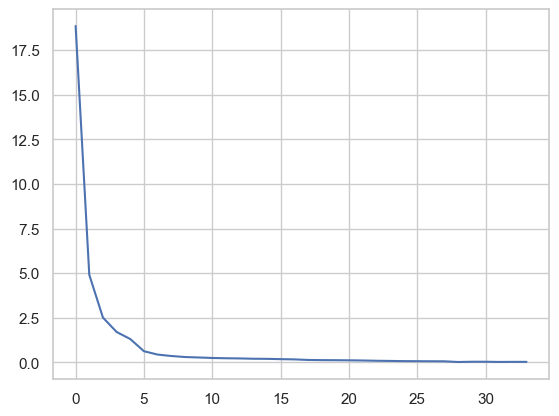

[18.8491442   4.91082457  2.51121968  1.70665278  1.30927179  0.62753979
  0.43931226  0.35950551  0.30147802  0.27677676  0.24896514  0.23252326
  0.22333056  0.20544558  0.20035624  0.18330501  0.17019445  0.13863386
  0.12832669  0.1245334   0.11821725  0.1076127   0.09255947  0.0833471
  0.07218427  0.06826828  0.06511574  0.0613974   0.02293761  0.03729554
  0.03753585  0.02663417  0.03038518  0.03104236]


In [11]:
# See how many components to keep in the FIFA 19 data
# Print a scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

Both the scree plot and the eigenvalues > 1 rule agree that you should keep only the first five components.  Now create $ P $, transform $ X $ into $ Y $, and look at how well our new component correlates with your old variables.  Ultimately, the solution encompasses over 86%  of the data's variance in just 5 components, rather than 34 variables.

There are PCA functions in both <code>matplotlib</code> and <code>scikit-learn</code> that will perform the PCA analysis for you.

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.55435606 0.14442806 0.07385533 0.05019291 0.03850587]


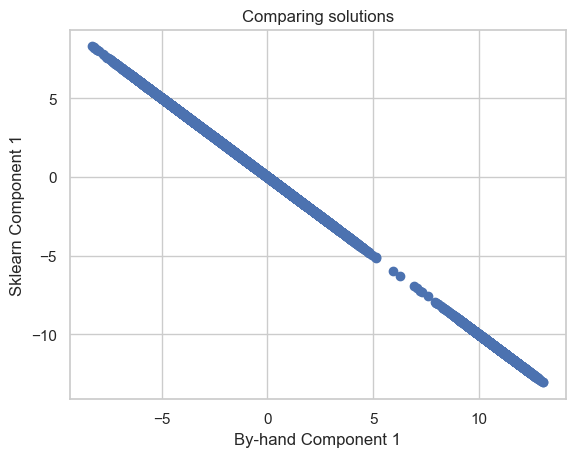

In [12]:
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:,0]

# Transform X into Y
Y = P.T.dot(Xt)

print(f"The percentage of total variance in the dataset explained by each component from Sklearn PCA.\n {sklearn_pca.explained_variance_ratio_}")

# Compare the sklearn solution to yours
plt.plot(Y_sklearn[:,0], Y, "o")
plt.title("Comparing solutions")
plt.ylabel("Sklearn Component 1")
plt.xlabel("By-hand Component 1")
plt.show();

## Assignment

In [2]:
kagle2 = dict(
    drivername="postgresql", 
    username="dsbc_student", 
    password="7*.8G9QH21", 
    host="142.93.121.174", 
    port="5432", 
    database="useducation"
)

engine = create_engine(URL(**kagle2), echo=True)

usedu_df = pd.read_sql_query("SELECT * FROM useducation", con=engine)

engine.dispose()

2019-12-03 09:17:42,148 INFO sqlalchemy.engine.base.Engine select version()
2019-12-03 09:17:42,149 INFO sqlalchemy.engine.base.Engine {}
2019-12-03 09:17:42,253 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-03 09:17:42,255 INFO sqlalchemy.engine.base.Engine {}
2019-12-03 09:17:42,358 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-03 09:17:42,363 INFO sqlalchemy.engine.base.Engine {}
2019-12-03 09:17:42,416 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-03 09:17:42,418 INFO sqlalchemy.engine.base.Engine {}
2019-12-03 09:17:42,470 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-03 09:17:42,472 INFO sqlalchemy.engine.base.Engine {}
2019-12-03 09:17:42,577 INFO sqlalchemy.engine.base.Engine SELECT * FROM useducation
2019-12-03 09:17:42,581 INFO sqlalchemy.engine.base.Engine {}


In [3]:
# As a reference print a list of column headers
print(*(x for x in usedu_df.columns), sep="\n")

PRIMARY_KEY
STATE
YEAR
ENROLL
TOTAL_REVENUE
FEDERAL_REVENUE
STATE_REVENUE
LOCAL_REVENUE
TOTAL_EXPENDITURE
INSTRUCTION_EXPENDITURE
SUPPORT_SERVICES_EXPENDITURE
OTHER_EXPENDITURE
CAPITAL_OUTLAY_EXPENDITURE
GRADES_PK_G
GRADES_KG_G
GRADES_4_G
GRADES_8_G
GRADES_12_G
GRADES_1_8_G
GRADES_9_12_G
GRADES_ALL_G
AVG_MATH_4_SCORE
AVG_MATH_8_SCORE
AVG_READING_4_SCORE
AVG_READING_8_SCORE


Number of null values: 1079


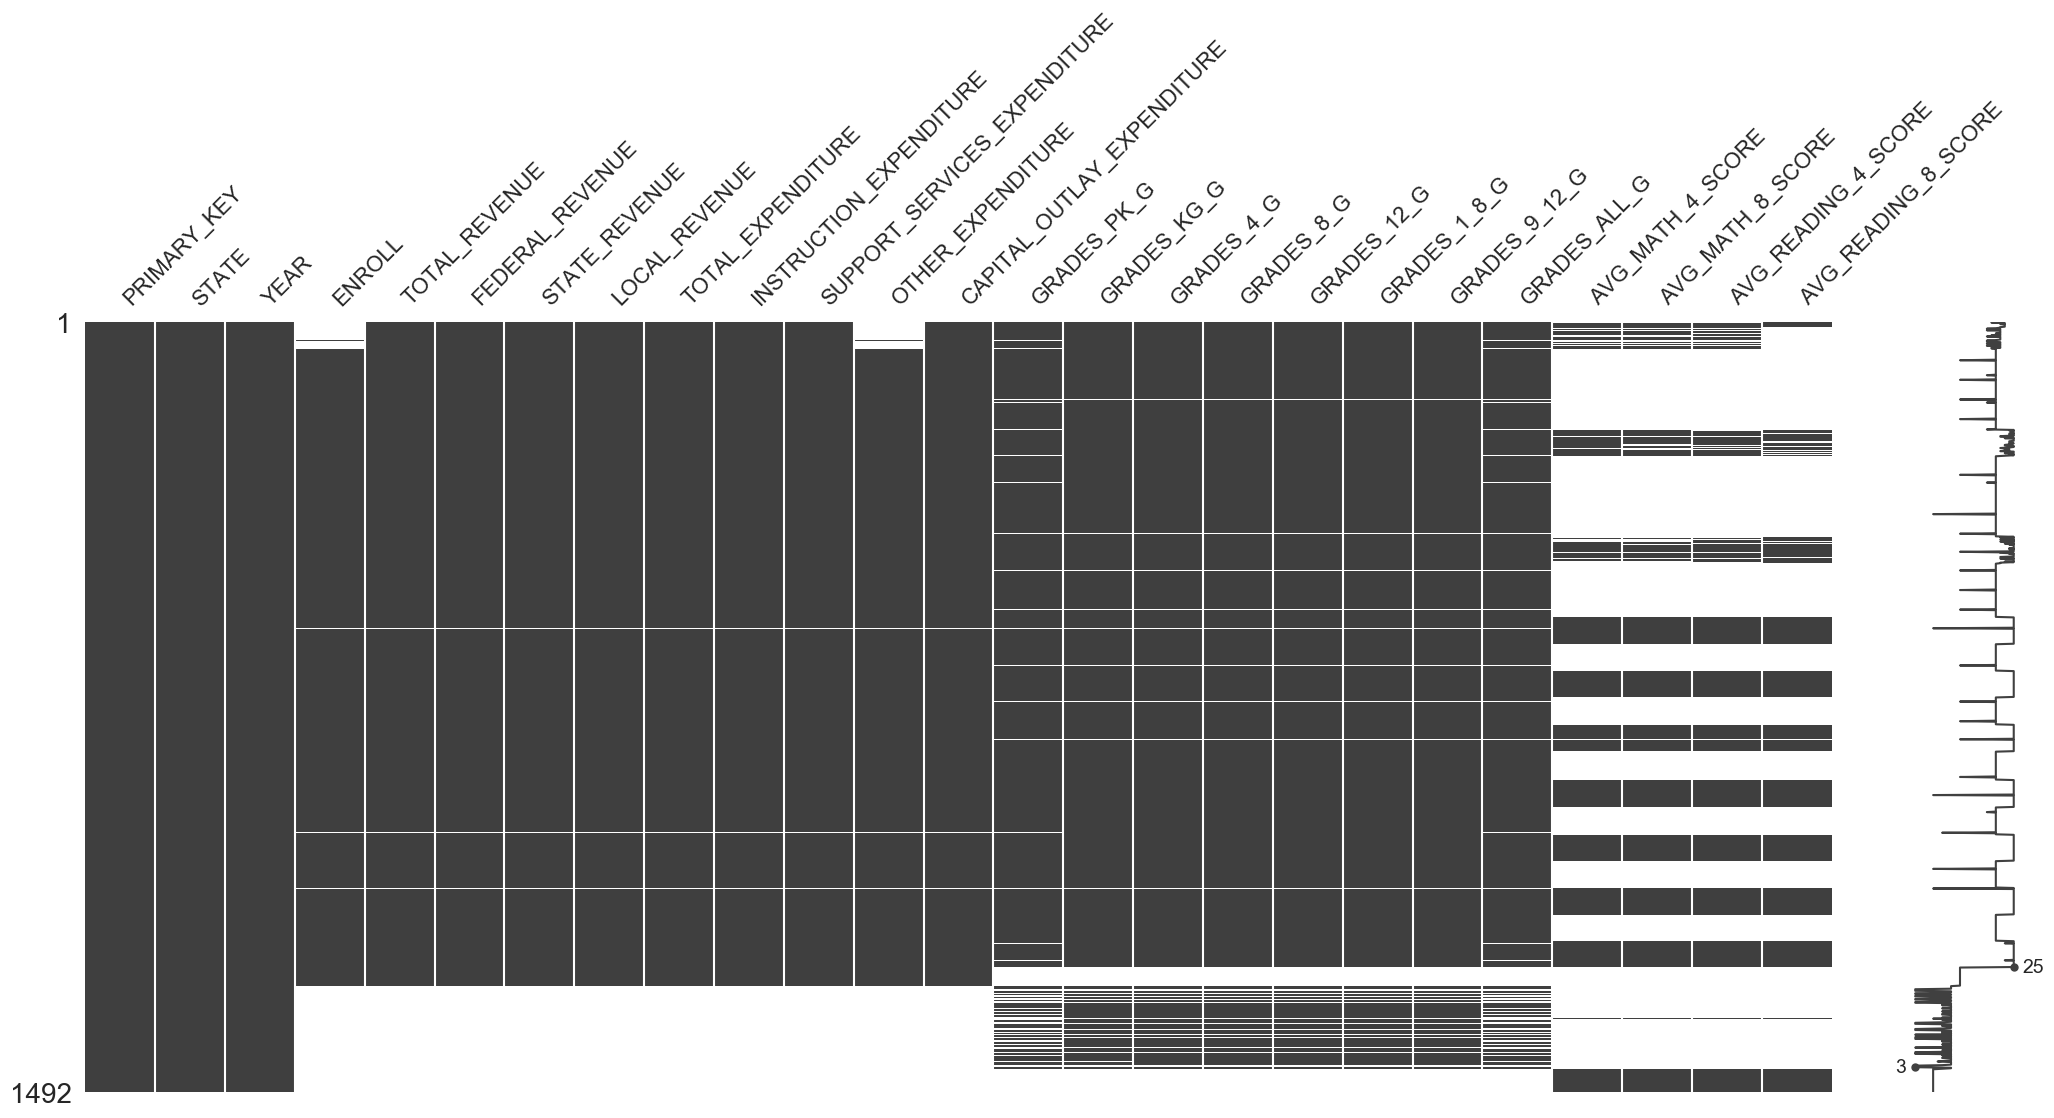

In [4]:
# Generate a report of entries with null values
def report_null_entries(df):
    if len(df[df.isnull().any(axis=1)] != 0):
        print(f"Number of null values: {len(df[df.isnull().any(axis=1)])}")
        missingno.matrix(df)
        plt.show()
    else:
        print("No rows with null values found.")

report_null_entries(usedu_df)

In [5]:
# Take a look at unique values to get a feel for possible categorical vs continuous values columns
usedu_df.nunique()

PRIMARY_KEY                     1487
STATE                             80
YEAR                              26
ENROLL                          1224
TOTAL_REVENUE                   1274
FEDERAL_REVENUE                 1275
STATE_REVENUE                   1251
LOCAL_REVENUE                   1275
TOTAL_EXPENDITURE               1275
INSTRUCTION_EXPENDITURE         1275
SUPPORT_SERVICES_EXPENDITURE    1275
OTHER_EXPENDITURE               1222
CAPITAL_OUTLAY_EXPENDITURE      1275
GRADES_PK_G                     1261
GRADES_KG_G                     1348
GRADES_4_G                      1340
GRADES_8_G                      1347
GRADES_12_G                     1342
GRADES_1_8_G                    1360
GRADES_9_12_G                   1358
GRADES_ALL_G                    1318
AVG_MATH_4_SCORE                 535
AVG_MATH_8_SCORE                 531
AVG_READING_4_SCORE              532
AVG_READING_8_SCORE              497
dtype: int64

In [6]:
# Alter the column types for the "STATE" and "YEAR" variables
usedu_df["STATE"] = usedu_df["STATE"].astype("category")
usedu_df["YEAR"] = pd.to_datetime(usedu_df["YEAR"], format="%Y")
usedu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null category
YEAR                            1492 non-null datetime64[ns]
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G            

In [7]:
categorical_cols = usedu_df.select_dtypes(include="category").columns
continuous_cols = usedu_df.select_dtypes(exclude=['object','category','datetime64[ns]']).columns

# Create a rowcount variable
df_len = len(usedu_df)

# Calculated the width of the longest column
max_col = len(max(usedu_df.columns, key=len))

for col in categorical_cols: 
    # Use sorted function to generate a list of the 5 shortest categories
    short_cats = sorted(set(usedu_df[col]), key=len)[:5]
    print(f"First five shortest strings in '{col}': {short_cats}")

# Look at null value information for continuous variables
for col in categorical_cols:
    empty_strings = len(usedu_df.loc[usedu_df[col]==''])
    nulls = usedu_df[col].isna().sum()
    tot_nulls = empty_strings + nulls
    pct_nan = tot_nulls*100/df_len
    print(f"{col:<{max_col}}: {tot_nulls:>{5}} nulls | percent null: {pct_nan:>{5}.2f}")

# Look a null value information for continuous variables
for col in continuous_cols:
    nulls = usedu_df[col].isnull().sum()
    pct_null = nulls*100/df_len
    print(f"{col:<{max_col}}: {nulls:>{5}} nulls | percent null: {pct_null:>{5}.2f}")

First five shortest strings in 'STATE': ['DD', 'AS', 'BI', 'MP', 'PR']
STATE                       :     0 nulls | percent null:  0.00
ENROLL                      :   263 nulls | percent null: 17.63
TOTAL_REVENUE               :   212 nulls | percent null: 14.21
FEDERAL_REVENUE             :   212 nulls | percent null: 14.21
STATE_REVENUE               :   212 nulls | percent null: 14.21
LOCAL_REVENUE               :   212 nulls | percent null: 14.21
TOTAL_EXPENDITURE           :   212 nulls | percent null: 14.21
INSTRUCTION_EXPENDITURE     :   212 nulls | percent null: 14.21
SUPPORT_SERVICES_EXPENDITURE:   212 nulls | percent null: 14.21
OTHER_EXPENDITURE           :   263 nulls | percent null: 17.63
CAPITAL_OUTLAY_EXPENDITURE  :   212 nulls | percent null: 14.21
GRADES_PK_G                 :   173 nulls | percent null: 11.60
GRADES_KG_G                 :   132 nulls | percent null:  8.85
GRADES_4_G                  :   131 nulls | percent null:  8.78
GRADES_8_G                  :   1

In [8]:
# Need to replace null values in the following columns
null_replace_cols = list(continuous_cols)

In [9]:
# Fill in null values in the continuous columns using interpolation
usedu_interpolated = usedu_df.copy()

# Get a list of states to iterate over
states = usedu_interpolated["STATE"].unique()

for state in states:
    usedu_interpolated.loc[usedu_interpolated["STATE"] == state, null_replace_cols]=usedu_interpolated.loc[usedu_interpolated["STATE"] == state, null_replace_cols].interpolate()

usedu_interpolated.dropna(inplace=True)

print("Interpolation complete.")

Interpolation complete.


### _1. Create a new score variable from the weighted averages of all score variables in the datasets._ Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.

In [10]:
usedu_interpolated["wt_avg"] = (((usedu_interpolated["AVG_MATH_4_SCORE"] + usedu_interpolated["AVG_READING_4_SCORE"]) * usedu_interpolated["GRADES_4_G"]) * 0.5 + ((usedu_interpolated["AVG_MATH_8_SCORE"] + usedu_interpolated["AVG_READING_8_SCORE"]) * usedu_interpolated["GRADES_8_G"]) * 0.5)/(usedu_interpolated["GRADES_4_G"] + usedu_interpolated["GRADES_8_G"])

usedu_interpolated.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,wt_avg
54,1993_ARIZONA,ARIZONA,1993-01-01,676297.0,3427976.0,318465.0,1415407.0,1694104.0,3623946.0,1578889.0,...,53500.0,37614.0,461398.0,182737.0,647299.0,215.834434,265.993417,206.291984,262.448330,236.637935
55,1993_ARKANSAS,ARKANSAS,1993-01-01,311432.0,1346909.0,128196.0,771079.0,447634.0,1376067.0,782791.0,...,36471.0,27169.0,280280.0,125801.0,407329.0,211.616130,257.647254,208.685273,266.423396,236.905842
57,1993_COLORADO,COLORADO,1993-01-01,539538.0,3058326.0,147793.0,1242337.0,1668196.0,3028305.0,1537714.0,...,47665.0,34770.0,403871.0,164260.0,575380.0,222.219036,273.200878,215.523979,266.856804,243.634022
58,1993_CONNECTICUT,CONNECTICUT,1993-01-01,471918.0,4064158.0,149204.0,1433539.0,2481415.0,4079943.0,2302852.0,...,34662.0,27979.0,310022.0,127655.0,443893.0,228.105503,275.202320,224.712775,264.457874,246.815311
59,1993_DELAWARE,DELAWARE,1993-01-01,104355.0,683954.0,44497.0,443250.0,196207.0,694534.0,394680.0,...,8265.0,5882.0,67899.0,28930.0,97394.0,217.181255,263.834857,207.792430,262.255809,237.735539


### _2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?_

,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,wt_avg
TOTAL_EXPENDITURE,1.000000,0.990829,0.993175,0.946483,0.928576,0.093020
INSTRUCTION_EXPENDITURE,0.990829,1.000000,0.975867,0.907235,0.889763,0.105787
SUPPORT_SERVICES_EXPENDITURE,0.993175,0.975867,1.000000,0.953789,0.913680,0.098643
OTHER_EXPENDITURE,0.946483,0.907235,0.953789,1.000000,0.924197,0.027635
CAPITAL_OUTLAY_EXPENDITURE,0.928576,0.889763,0.913680,0.924197,1.000000,0.010670
wt_avg,0.093020,0.105787,0.098643,0.027635,0.010670,1.000000


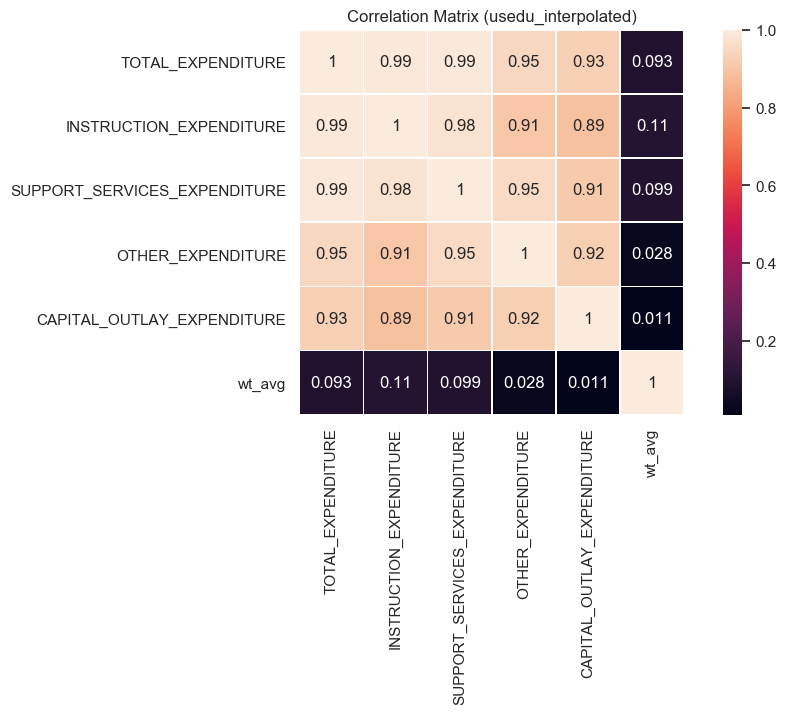

In [11]:
# List of variables interested in correlating
corr_vars = ["TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "wt_avg"]

display(usedu_interpolated[corr_vars].corr())

plt.figure(figsize=(10,5))

sns.heatmap(usedu_interpolated[corr_vars].corr(), square=True, annot=True, linewidth=0.5)
plt.title("Correlation Matrix (usedu_interpolated)")
# Fix display issues for this version of matplotlib
b,t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
# plt.yticks(rotation=360)

plt.show();

The weighted average is most tightly correlated to SUPPORT_SERVICES_EXPENDITURE followed by TOTAL_EXPENDATURE.

### _3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?_

In [12]:
# Normalize the data so that all variables have a mean of 0 and standard deviation of 1
X = StandardScaler().fit_transform(usedu_interpolated[corr_vars[:-1]]) # Leave off the weighted_average variable

# Transform X so that the variables are represented by rows
Xt = X.T

# Create the covariance matrix
Cx = np.cov(Xt)

# Calculate eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

sklearn_pca = PCA(n_components=1)
usedu_interpolated["pca_1"] = sklearn_pca.fit_transform(X)
var_pct = list(sklearn_pca.explained_variance_ratio_)[0]

print(f"The percentage of total variance in the dataset explained by each component from Sklearn PCA: {var_pct:.6%}")

The percentage of total variance in the dataset explained by each component from Sklearn PCA: 95.411680%


### _4. What is the correlation between the overall score variable and the 1st principal component?_

,wt_avg,pca_1
wt_avg,1.000000,0.069272
pca_1,0.069272,1.000000


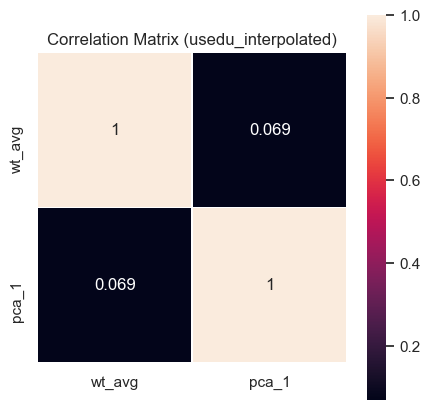

In [13]:
display(usedu_interpolated[[corr_vars[-1], usedu_interpolated.columns[-1]]].corr())

plt.figure(figsize=(5,5))

sns.heatmap(usedu_interpolated[[corr_vars[-1],usedu_interpolated.columns[-1]]].corr(), square=True, annot=True, linewidth=0.5)
plt.title("Correlation Matrix (usedu_interpolated)")
# Fix display issues for this version of matplotlib
b,t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
# plt.yticks(rotation=360)

plt.show();

The two correlate at 69%

### _5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?_

,wt_avg,pca_1,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
wt_avg,1.000000,0.069272,0.093020,0.105787,0.098643,0.027635,0.010670
pca_1,0.069272,1.000000,0.995210,0.975856,0.990651,0.968760,0.952869
TOTAL_EXPENDITURE,0.093020,0.995210,1.000000,0.990829,0.993175,0.946483,0.928576
INSTRUCTION_EXPENDITURE,0.105787,0.975856,0.990829,1.000000,0.975867,0.907235,0.889763
SUPPORT_SERVICES_EXPENDITURE,0.098643,0.990651,0.993175,0.975867,1.000000,0.953789,0.913680
OTHER_EXPENDITURE,0.027635,0.968760,0.946483,0.907235,0.953789,1.000000,0.924197
CAPITAL_OUTLAY_EXPENDITURE,0.010670,0.952869,0.928576,0.889763,0.913680,0.924197,1.000000


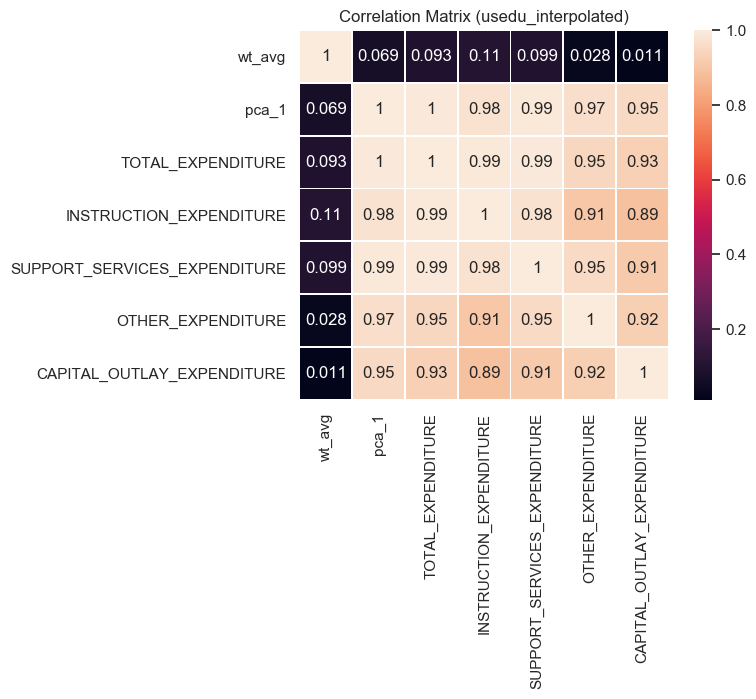

In [14]:
cols = list(usedu_interpolated.columns[-2:])+list(usedu_interpolated.columns[8:13])
display(usedu_interpolated[cols].corr())

sns.heatmap(usedu_interpolated[cols].corr(), square=True, annot=True, linewidth=0.5)
plt.title("Correlation Matrix (usedu_interpolated)")
# Fix display issues for this version of matplotlib
b,t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
# plt.yticks(rotation=360)

plt.show();

The expenditure variables, "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE", and "SUPPORT_SERVICES_EXPENDITURE" are more closely correlated to the "wt_avg" variable than the first principal component.